In [ ]:
! pip install --quiet underthesea
! pip install --quiet vncorenlp
! pip install --quiet py_vncorenlp
! pip install --quiet python-rdrsegmenter
! pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
"""train = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/train.xlsx")
test = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/test.xlsx")

train, valid = train_test_split(train, test_size = 0.1, random_state = 60)
train.to_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/train.xlsx")
valid.to_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/valid.xlsx")"""

'train = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/train.xlsx")\ntest = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/test.xlsx")\n\ntrain, valid = train_test_split(train, test_size = 0.1, random_state = 60)\ntrain.to_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/train.xlsx")\nvalid.to_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/valid.xlsx")'

In [ ]:
# see data preprocessing steps at link:
# https://colab.research.google.com/drive/1AuvWD-Lo6UIjyb_fmjxGB1zLZWZQ7GFf?ouid=115125045212634117084&usp=drive_link
from distutils.dir_util import copy_tree
copy_tree("/content/drive/MyDrive/Thesis: Topic Modelling/Code/utils", "./utils/")

from utils.data_preprocessing_v2 import *
import seaborn as sns
import numpy as np
import pandas as pd
import re
import string
from underthesea import word_tokenize, text_normalize
from gensim.models import word2vec
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import mode
from vncorenlp import VnCoreNLP
from sklearn.metrics import hamming_loss
from sklearn.multioutput import ClassifierChain


with open("/content/drive/MyDrive/Thesis: Topic Modelling/Code/utils/vietnamese-stopwords.txt") as f:
    STOPWORDS = f.readlines()
    STOPWORDS = [remove_all_tag(i) for i in STOPWORDS]


def evaluate(y_true, y_pred, eval_individual = True, model_name = ""):
  label_cols = ["Quality", "Pack", "Serve", "Shipping", "Price", "Other"]
  print(f"Classification report from {model_name}")
  print(classification_report(y_true[label_cols], y_pred))
  print('Hamming Loss: ', round(hamming_loss(y_true, y_pred),3))
  if eval_individual:
    for i in range(len(label_cols)):
      print(f"classification report of {label_cols[i]}")
      print(classification_report(y_true[label_cols[i]], y_pred[:, i]))


def evaluate_chain(model, X_train, y_train, X_test, y_test, predict_proba = True):
  chains = [ClassifierChain(model, order="random", random_state=i) for i in range(10)]
  ovr = OneVsRestClassifier(model)
  ovr.fit(X_train, y_train)
  Y_pred_ovr = ovr.predict(X_test)
  ovr_hamming_loss = hamming_loss(y_test, Y_pred_ovr)
  for chain in chains:
    chain.fit(X_train, y_train)
  if predict_proba:
    Y_pred_chains = np.array([chain.predict_proba(X_test) for chain in chains])
    Y_pred_ensemble = Y_pred_chains.mean(axis=0)
    Y_pred_ensemble = Y_pred_ensemble >= 0.5
  else:
    Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    Y_pred_ensemble = mode(Y_pred_chains, axis = 0)[0]
  chain_hamming_loss = [
      hamming_loss(y_test, Y_pred_chain >= 0.5)
      for Y_pred_chain in Y_pred_chains
  ]
  ensemble_hamming_loss = hamming_loss(y_test, Y_pred_ensemble)
  scores = [ovr_hamming_loss] + chain_hamming_loss + [ensemble_hamming_loss]
  evaluate(y_test, Y_pred_ovr, eval_individual = False, model_name = "One Vs Rest model")
  evaluate(y_test, Y_pred_ensemble, eval_individual = False, model_name = "Ensemble model from classifier chain")
  return scores

def train_ovr(base_model, X_train, y_train):
  ovr = OneVsRestClassifier(base_model)
  ovr.fit(X_train, y_train)
  return ovr

def displayConfusionMatrix(y_true, y_pred, label = "Dataset"):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred, #np.argmax(y_pred, axis=1),
        display_labels=["0","1"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + f" {label} -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
train = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/train.xlsx")
test = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/test.xlsx")
valid = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/valid.xlsx")

for i in [train,test, valid]:
  print(i.shape)

(12240, 11)
(3401, 10)
(1361, 11)


In [ ]:
labels_cols = ["Quality", "Pack", "Serve", "Shipping", "Price", "Other"]
train = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/train.xlsx")
train["comment"] = train["comment"].astype(str)
train["clean_comment"] = train["comment"].apply(lambda x: cleaning(x))
X_train = train["clean_comment"]
y_train = train[labels_cols]

test = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/test.xlsx")
test["comment"] = test["comment"].astype(str)
test["clean_comment"] = test["comment"].apply(lambda x: cleaning(x))
X_test = test["clean_comment"]
y_test = test[labels_cols]

valid = pd.read_excel("/content/drive/MyDrive/Thesis: Topic Modelling/Data/Splitted data/test.xlsx")
valid["comment"] = valid["comment"].astype(str)
valid["clean_comment"] = valid["comment"].apply(lambda x: cleaning(x))
X_valid = valid["clean_comment"]
y_valid = valid[labels_cols]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 3), (1, 5)],
    'tfidf__stop_words': [STOPWORDS, None],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [2, 3, 4],
    'tfidf__smooth_idf': [True, False],
}

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('ovr', OneVsRestClassifier(LogisticRegression(random_state = 42)))
])

# Initialize the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(best_params)


{'tfidf__max_df': 0.75, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 1), 'tfidf__smooth_idf': True, 'tfidf__stop_words': ['a lô ', 'a ha ', 'ai ', 'ai ai ', 'ai nấy ', 'ai đó ', 'alô ', 'amen ', 'anh ', 'anh ấy ', 'ba ', 'ba ba ', 'ba bản ', 'ba cùng ', 'ba họ ', 'ba ngày ', 'ba ngôi ', 'ba tăng ', 'bao giờ ', 'bao lâu ', 'bao nhiêu ', 'bao nả ', 'bay biến ', 'biết ', 'biết bao ', 'biết bao nhiêu ', 'biết chắc ', 'biết chừng nào ', 'biết mình ', 'biết mấy ', 'biết thế ', 'biết trước ', 'biết việc ', 'biết đâu ', 'biết đâu chừng ', 'biết đâu đấy ', 'biết được ', 'buổi ', 'buổi làm ', 'buổi mới ', 'buổi ngày ', 'buổi sớm ', 'bà ', 'bà ấy ', 'bài ', 'bài bác ', 'bài bỏ ', 'bài cái ', 'bác ', 'bán ', 'bán cấp ', 'bán dạ ', 'bán thế ', 'bây bẩy ', 'bây chừ ', 'bây giờ ', 'bây nhiêu ', 'bèn ', 'béng ', 'bên ', 'bên bị ', 'bên có ', 'bên cạnh ', 'bông ', 'bước ', 'bước khỏi ', 'bước tới ', 'bước đi ', 'bạn ', 'bản ', 'bản bộ ', 'bản riêng ', 'bản thân ', 'bản ý ', 'bất chợt ', 'bất cứ ', 'bấ

In [ ]:
param_grid = {
    'bow__ngram_range': [(1, 1), (1, 3), (1, 5)],
    'bow__stop_words': [STOPWORDS, None],
    'bow__max_df': [0.5, 0.75, 1.0],
    'bow__min_df': [2, 3, 4]
}

# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('ovr', OneVsRestClassifier(LogisticRegression(random_state = 42)))
])

# Initialize the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(best_params)

{'bow__max_df': 0.75, 'bow__min_df': 2, 'bow__ngram_range': (1, 3), 'bow__stop_words': ['a lô ', 'a ha ', 'ai ', 'ai ai ', 'ai nấy ', 'ai đó ', 'alô ', 'amen ', 'anh ', 'anh ấy ', 'ba ', 'ba ba ', 'ba bản ', 'ba cùng ', 'ba họ ', 'ba ngày ', 'ba ngôi ', 'ba tăng ', 'bao giờ ', 'bao lâu ', 'bao nhiêu ', 'bao nả ', 'bay biến ', 'biết ', 'biết bao ', 'biết bao nhiêu ', 'biết chắc ', 'biết chừng nào ', 'biết mình ', 'biết mấy ', 'biết thế ', 'biết trước ', 'biết việc ', 'biết đâu ', 'biết đâu chừng ', 'biết đâu đấy ', 'biết được ', 'buổi ', 'buổi làm ', 'buổi mới ', 'buổi ngày ', 'buổi sớm ', 'bà ', 'bà ấy ', 'bài ', 'bài bác ', 'bài bỏ ', 'bài cái ', 'bác ', 'bán ', 'bán cấp ', 'bán dạ ', 'bán thế ', 'bây bẩy ', 'bây chừ ', 'bây giờ ', 'bây nhiêu ', 'bèn ', 'béng ', 'bên ', 'bên bị ', 'bên có ', 'bên cạnh ', 'bông ', 'bước ', 'bước khỏi ', 'bước tới ', 'bước đi ', 'bạn ', 'bản ', 'bản bộ ', 'bản riêng ', 'bản thân ', 'bản ý ', 'bất chợt ', 'bất cứ ', 'bất giác ', 'bất kì ', 'bất kể ', 'bấ

In [ ]:
bow = CountVectorizer(ngram_range=(1, 3), tokenizer=word_tokenize, stop_words=STOPWORDS,max_df=0.75, min_df=2)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=STOPWORDS,max_df=0.75, min_df=4, smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_bow.shape

(12240, 40385)

In [ ]:
X_train_tfidf

<12240x2724 sparse matrix of type '<class 'numpy.float64'>'
	with 190383 stored elements in Compressed Sparse Row format>

In [ ]:
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/transformers/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

X_train_tokenized = [rdrsegmenter.tokenize(corpus)[0] for corpus in X_train.values]
X_test_tokenized = [rdrsegmenter.tokenize(corpus)[0] for corpus in X_test.values]
vs = 150 # number of dimensions that our words are going to be embedded in
context_size = 5 # context window
min_word = 10 # minimal number of occurence to be included in the embedded corpus

skipgram = word2vec.Word2Vec(X_train_tokenized, vector_size = vs, \
                            window=context_size, min_count=min_word, \
                            epochs=50, seed=42, sg = 1)

vs_cbow = 150 # number of dimensions that our words are going to be embedded in
context_size_cbow = 5 # context window

cbow = word2vec.Word2Vec(X_train_tokenized, vector_size = vs_cbow, \
                            window=context_size_cbow, min_count=min_word, \
                            epochs=50, seed=42, sg = 0)

# Get words and indexes from the word2vec model


In [ ]:
word_vec_unpack = [(word, idx) for word, idx in \
                   skipgram.wv.key_to_index.items()]
tokens, indexes = zip(*word_vec_unpack)
word_vec_df = pd.DataFrame(skipgram.wv.vectors[indexes, :], index=tokens)
X_train_skipgram = np.array([word_vec_df.loc[list(set(doc).intersection(set(word_vec_df.index)))].mean(axis=0) for doc in X_train_tokenized])
X_test_skipgram = np.array([word_vec_df.loc[list(set(doc).intersection(set(word_vec_df.index)))].mean(axis=0) for doc in X_test_tokenized])


word_vec_unpack = [(word, idx) for word, idx in \
                   cbow.wv.key_to_index.items()]
tokens, indexes = zip(*word_vec_unpack)
word_vec_df = pd.DataFrame(cbow.wv.vectors[indexes, :], index=tokens)
X_train_cbow = np.array([word_vec_df.loc[list(set(doc).intersection(set(word_vec_df.index)))].mean(axis=0) for doc in X_train_tokenized])
X_test_cbow = np.array([word_vec_df.loc[list(set(doc).intersection(set(word_vec_df.index)))].mean(axis=0) for doc in X_test_tokenized])


In [ ]:
X_train_skipgram = pd.DataFrame(X_train_skipgram).fillna(0)
X_test_skipgram = pd.DataFrame(X_test_skipgram).fillna(0)
X_train_cbow = pd.DataFrame(X_train_cbow).fillna(0)
X_test_cbow = pd.DataFrame(X_test_cbow).fillna(0)

In [ ]:
lr_model = LogisticRegression()
xgb_model = xgb.XGBClassifier()
nb_model = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2',
  alpha=1e-3, random_state=42,
  max_iter=5, tol=None)


models_list = [("Logistic Regression", lr_model), ("XGBoost", xgb_model), ("Naive Bayes", nb_model), ("SVM", sgd)]


# 1. Evaluate Bow models


In [ ]:
# bow evaluation


score_dict = {}
for name, model in models_list:
  if name == "SVM":
    predict_proba = 0
  else:
    predict_proba = 1
  print(f"evaluating {name}")
  score_dict[name] = evaluate_chain(model, X_train_bow, y_train, X_test_bow, y_test, predict_proba = predict_proba)


evaluating Logistic Regression
Classification report from One Vs Rest model
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2721
           1       0.97      0.91      0.94       581
           2       0.92      0.78      0.84       518
           3       0.93      0.89      0.91      1366
           4       0.96      0.83      0.89       509
           5       0.87      0.77      0.81       309

   micro avg       0.93      0.90      0.91      6004
   macro avg       0.93      0.86      0.89      6004
weighted avg       0.93      0.90      0.91      6004
 samples avg       0.91      0.90      0.89      6004

Hamming Loss:  0.051
Classification report from Ensemble model from classifier chain
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2721
           1       0.97      0.91      0.94       581
           2       0.92      0.79      0.85       518
           3       0.93  

# 2. TFIDF evaluation


In [ ]:
# tfidf evaluation
score_dict = {}
for name, model in models_list:
  if name == "SVM":
    predict_proba = 0
  else:
    predict_proba = 1
  print(f"evaluating {name}")
  score_dict[name] = evaluate_chain(model, X_train_tfidf, y_train, X_test_tfidf, y_test, predict_proba = predict_proba)

evaluating Logistic Regression
Classification report from One Vs Rest model
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2721
           1       0.98      0.84      0.90       581
           2       0.93      0.68      0.78       518
           3       0.93      0.87      0.90      1366
           4       0.97      0.74      0.84       509
           5       0.91      0.47      0.62       309

   micro avg       0.92      0.86      0.89      6004
   macro avg       0.94      0.76      0.83      6004
weighted avg       0.93      0.86      0.89      6004
 samples avg       0.89      0.86      0.86      6004

Hamming Loss:  0.062
Classification report from Ensemble model from classifier chain
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2721
           1       0.97      0.84      0.90       581
           2       0.92      0.68      0.78       518
           3       0.93  

# 3. Word2vec (Skipgram) evaluation

In [ ]:
# word2vec (skipgram) evaluation
models_list = [("Logistic Regression", lr_model), ("XGBoost", xgb_model), ("SVM", sgd)]
score_dict = {}
for name, model in models_list:
  if name == "SVM":
    predict_proba = 0
  else:
    predict_proba = 1
  print(f"evaluating {name}")
  score_dict[name] = evaluate_chain(model, X_train_skipgram, y_train, X_test_skipgram, y_test, predict_proba = predict_proba)

evaluating Logistic Regression
Classification report from One Vs Rest model
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2721
           1       0.89      0.73      0.81       581
           2       0.83      0.56      0.67       518
           3       0.86      0.79      0.82      1366
           4       0.85      0.55      0.67       509
           5       0.86      0.68      0.76       309

   micro avg       0.87      0.81      0.84      6004
   macro avg       0.86      0.71      0.77      6004
weighted avg       0.87      0.81      0.84      6004
 samples avg       0.87      0.84      0.83      6004

Hamming Loss:  0.089
Classification report from Ensemble model from classifier chain
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2721
           1       0.90      0.73      0.81       581
           2       0.84      0.58      0.68       518
           3       0.87  

# 4. Word2vec cbow evalutaion

In [ ]:
# word2vec (cbow) evaluation
score_dict = {}
for name, model in models_list:
  if name == "SVM":
    predict_proba = 0
  else:
    predict_proba = 1
  print(f"evaluating {name}")
  score_dict[name] = evaluate_chain(model, X_train_cbow, y_train, X_test_cbow, y_test, predict_proba = predict_proba)

evaluating Logistic Regression
Classification report from One Vs Rest model
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2721
           1       0.92      0.82      0.87       581
           2       0.84      0.66      0.74       518
           3       0.89      0.85      0.87      1366
           4       0.90      0.67      0.77       509
           5       0.85      0.75      0.79       309

   micro avg       0.89      0.86      0.87      6004
   macro avg       0.88      0.78      0.83      6004
weighted avg       0.89      0.86      0.87      6004
 samples avg       0.89      0.87      0.86      6004

Hamming Loss:  0.074
Classification report from Ensemble model from classifier chain
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2721
           1       0.93      0.82      0.87       581
           2       0.84      0.67      0.74       518
           3       0.89  

In [ ]:
phobert_test = pd.read_csv("/content/drive/MyDrive/Thesis: Topic Modelling/Code/Phobert result/phobert_test_feature.csv").drop("Unnamed: 0", axis = 1)
phobert_train = pd.read_csv("/content/drive/MyDrive/Thesis: Topic Modelling/Code/Phobert result/phobert_train_feature.csv").drop("Unnamed: 0", axis = 1)

In [ ]:
phobert_train.shape

(12240, 768)

# 4. Evaluate embedding from Phobert

In [ ]:
import torch
save_best_path =  "/content/drive/MyDrive/THESIS DSEB62: Product review analysis/Baseline-model/Phobertv2" + "/best.pth"
model = torch.load(save_best_path)
embedder = model.roberta

import random
from tqdm import tqdm_notebook
device = 'cuda'
phobert = embedder.to(device)
with torch.no_grad():
    phobert.eval()
    train_embedded_mean = []
    train_embedded_pooling = []
    for step, batch in tqdm_notebook(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        last_hidden_layer = phobert(b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask)
        embedded_value_mean = torch.mean(last_hidden_layer[0], dim=1)
        embedded_value_pool = last_hidden_layer[0]
        train_embedded_mean.append(embedded_value_mean)
        train_embedded_pooling.append(embedded_value_pool)

In [ ]:
# phobert embedding evaluation
score_dict = {}
for name, model in models_list:
  if name == "SVM":
    predict_proba = 0
  else:
    predict_proba = 1
  print(f"evaluating {name}")
  score_dict[name] = evaluate_chain(model, phobert_train, y_train, phobert_test, y_test, predict_proba = predict_proba)

evaluating Logistic Regression
Classification report from One Vs Rest model
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2721
           1       0.98      0.98      0.98       581
           2       0.94      0.93      0.94       518
           3       0.94      0.97      0.96      1366
           4       0.97      0.96      0.97       509
           5       0.95      0.95      0.95       309

   micro avg       0.96      0.97      0.96      6004
   macro avg       0.96      0.96      0.96      6004
weighted avg       0.96      0.97      0.96      6004
 samples avg       0.96      0.97      0.96      6004

Hamming Loss:  0.022
Classification report from Ensemble model from classifier chain
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2721
           1       0.98      0.98      0.98       581
           2       0.94      0.93      0.94       518
           3       0.94  

In [ ]:
lr = LogisticRegression()
lr_trained = train_ovr(lr, phobert_train, y_train)

In [ ]:
best_prediction = lr_trained.predict(phobert_test)
best_proba = lr_trained.predict_proba(phobert_test)

In [ ]:
best_result_df = classification_report(y_test, best_prediction, target_names = y_test.columns, output_dict = True)
pd.DataFrame(best_result_df).T.to_excel("best_result_df.xlsx")

In [ ]:
evaluate(y_test, best_prediction)

Classification report from 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2721
           1       0.98      0.98      0.98       581
           2       0.94      0.93      0.94       518
           3       0.94      0.97      0.96      1366
           4       0.97      0.96      0.97       509
           5       0.95      0.95      0.95       309

   micro avg       0.96      0.97      0.96      6004
   macro avg       0.96      0.96      0.96      6004
weighted avg       0.96      0.97      0.96      6004
 samples avg       0.96      0.97      0.96      6004

Hamming Loss:  0.022
classification report of Quality
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       680
           1       0.96      0.97      0.97      2721

    accuracy                           0.95      3401
   macro avg       0.92      0.91      0.91      3401
weighted avg       0.94      0.95      0.95      

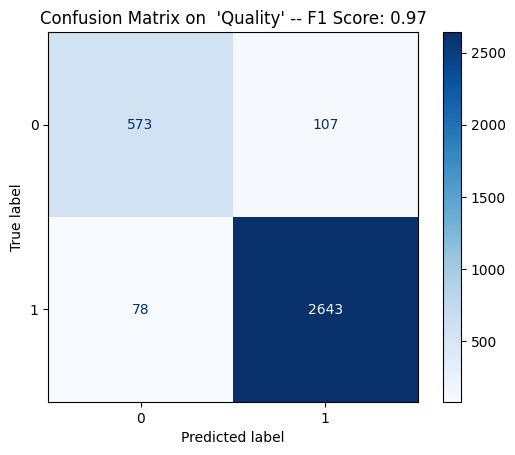

In [ ]:
displayConfusionMatrix(y_test["Quality"], best_prediction[:,0], label = "'Quality'")

In [ ]:
def displayConfusionMatrix(y_true, y_pred, label = "Dataset"):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred, #np.argmax(y_pred, axis=1),
        display_labels=["0","1"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + f" {label} -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
predict_proba_columns = ["Predict_" + i for i in y_test.columns]
result_df = test.copy()
result_df[predict_proba_columns] = best_proba

In [ ]:
result_df.to_excel("best_prediction.xlsx")

In [ ]:
evaluate_chain(sgd, phobert_train, y_train, phobert_test, y_test, predict_proba = predict_proba)

Classification report from One Vs Rest model
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2721
           1       0.98      0.98      0.98       581
           2       0.95      0.92      0.93       518
           3       0.94      0.97      0.95      1366
           4       0.96      0.97      0.97       509
           5       0.93      0.96      0.94       309

   micro avg       0.95      0.97      0.96      6004
   macro avg       0.95      0.96      0.96      6004
weighted avg       0.95      0.97      0.96      6004
 samples avg       0.96      0.97      0.96      6004

Hamming Loss:  0.024
Classification report from Ensemble model from classifier chain
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2721
           1       0.98      0.98      0.98       581
           2       0.95      0.91      0.93       518
           3       0.94      0.98      0.96      1366
  

[0.02362050377339998,
 0.02342448299519749,
 0.02298343624424189,
 0.022885425855140643,
 0.024355581691659314,
 0.023277467411545624,
 0.02401254532980496,
 0.023669508967950604,
 0.023277467411545624,
 0.02381652455160247,
 0.023473488189748114,
 0.023130451827893757]